# term1_sprint6 機械学習スクラッチ 決定木

## 2.決定木学習とは

決定木学習は 決定木 と呼ばれる 木構造のグラフ を作る機械学習手法です。機械学習の分野では学習手法も単に「決定木」と呼ばれます。


分類にも回帰にも使え、分類の場合3クラス以上の多値分類が可能です。ここでは基本となる分類のみを扱います。

## 決定木とは
決定木は、属性 と 値 の組｛属性1：値1，属性2：値2, 属性3：値3,…，属性n：値n｝によって表現されたデータを、条件分岐を繰り返すことであるクラスに割り当てることができる木構造のグラフです。


以下の例は会場の気温という属性の値によって、開催と中止のクラスに割り当てるグラフです。「会場の気温という属性の値は35以上かどうか」という条件分岐1回による決定木による分類が行えます。例えば36度がこの決定木にインプットされれば、中止というアウトプット（判断）ができます。

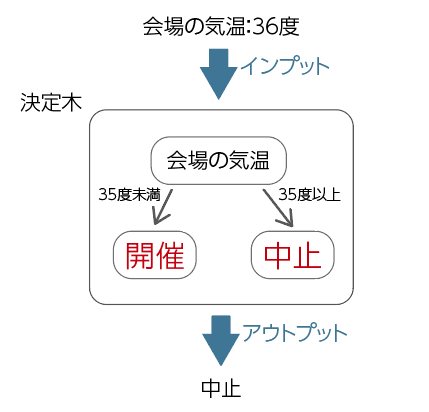

なお、「属性と値」は機械学習の分野では「特徴量の名前と特徴量の値」のことです。これ以降は単に特徴量という呼びます。

## 各種用語
もう少し複雑な例で決定木で重要な用語を確認します。特徴量が「雨量」「屋内かどうか」「風の強さ」の3種類で、イベントの開催か中止かを分類する場合で考えてみます。訓練データを学習することで、以下のような決定木が作れます。
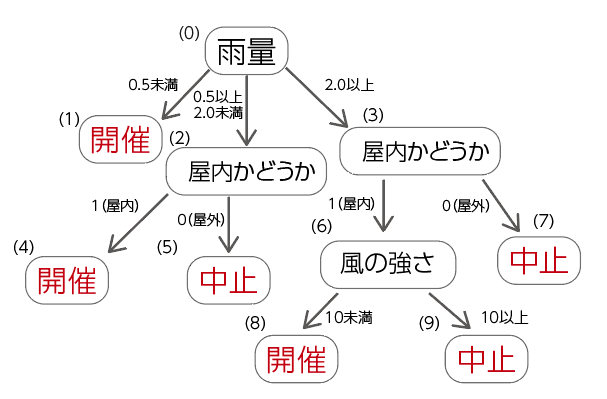

丸で囲われたひとつひとつを ノード と呼びます。ノードには親子関係を考えることができ、例えば(0)のノードは(1)(2)(3)のノードの 親ノード と呼びます。逆に、(1)(2)(3)のノードは(0)のノードの 子ノード と呼びます。


一番上の(0)は 根ノード 、 末端の(1)(4)(5)(7)(8)(9)のような分類結果を表すノードは 葉ノード と呼びます。


条件分岐の矢印は エッジ と呼びます。あるノードから根ノードまでのエッジの数が 深さ です。(3)の深さは1、(6)の深さは2、(9)の深さは3という風になります。この決定木の最大の深さは3です。


これは(0)に対して(1)(2)(3)の3つのノードが分かれている多岐分岐の決定木ですが、機械学習では2つにしか分かれないものが一般的です。学習時の複雑さを減らすためです。

## どう決定木を作るか
決定木の学習には様々なやり方が存在しますが、その中のある方法についてスクラッチを行いながら見ていきます。


学習方法やハイパーパラメータ、訓練データ次第で作られる決定木は異なってきます。

## 推定を考える
以下の場合、イベントは開催されるでしょうか。決定木を使って判断してください。

答えは「開催」です。以下の赤線の順でたどっていきます。

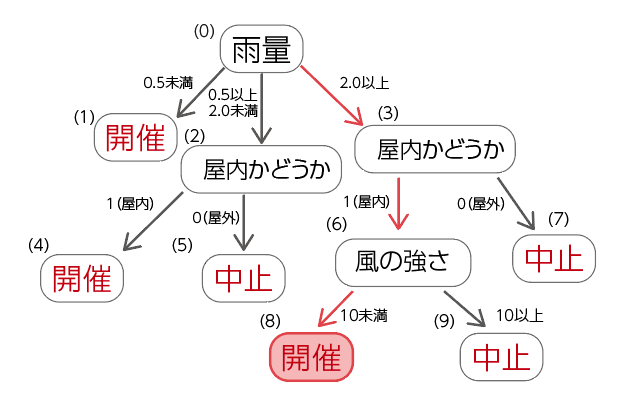

これが決定木による推定の操作になります。

## 扱える特徴量
決定木は理論上は量的変数だけでなく、カテゴリ変数も扱えます。しかし、scikit-learnの実装では量的変数のみに対応していますので、スクラッチ実装もそのように作成します。上記の例ですと「会場の種類」で「屋内と屋外」ですとカテゴリ変数ですが、「屋内かどうか」で「0と1」と量的変数にすることで扱えるようにしています。

# 3.決定木スクラッチ

分類のための決定木のクラスをスクラッチで作成していきます。NumPyなど最低限のライブラリのみを使いアルゴリズムを実装していきます。


決定木の学習には何回まで条件分岐を繰り返すかを表す （最大の）深さ というハイパーパラメータが登場しますが、深さ1の実装を必須課題とします。深さが2以上のものはアドバンス課題とします。


学習の仕方には様々な方法がありますが、ここではscikit-learnでも使用されている CART法 をベースとした実装を行います。この方法では学習の複雑さを減らすために、 分岐は2つに分かれるのみ になります。


以下に雛形を用意してあります。このScratchDecesionTreeClassifierDepth1クラスにコードを書き加えていってください。

《雛形》

In [1]:
class ScratchDecesionTreeClassifierDepth1():
    """
    深さ1の決定木分類器のスクラッチ実装

    Parameters
    ----------
    verbose : bool
      学習過程を出力する場合はTrue
    """
    def __init__(self, verbose=False):
        # ハイパーパラメータを属性として記録
        self.verbose = verbose
    def fit(self, X, y):
        """
        決定木分類器を学習する
        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            訓練データの特徴量
        y : 次の形のndarray, shape (n_samples, )
            訓練データの正解値
        """
        if self.verbose:
            #verboseをTrueにした際は学習過程を出力
            print()
        pass
    def predict(self, X):
        """
        決定木分類器を使いラベルを推定する
        """
        pass
        return

### 0.0.0（基本モジュールインポート】

In [2]:
# 基本ライブラリのインポート
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 30)
import matplotlib.pyplot as plt
import seaborn as sns

## 分割の条件を学習で求める
学習によって、ノードをどういった条件で分割すると、うまく分けられるかということを求めます。
うまく分けられていることを判定するためにノードに対してジニ不純度と情報利得という値を計算します。

### 【問題1】不純度を求める関数
ノードのジニ不純度を計算する関数を作成してください。ノード$t$に対するジニ不純度$I(t)$は以下の数式で求まります。
クラスが混じり合っているほどジニ不純度は高くなります。

$$I(t) = 1-\sum_{i=1}^{K}P^2(C_i|t) = 1-\sum_{i=1}^{K}(\frac{N_{t,i}}{N_{t,all}})^{2}$$

t
 : ノードのインデックス


i
 : クラスのインデックス


K
 : クラスの数


C
i
 : i番目のクラス


P
(
C
i
|
t
)
 :　t番目のノードにおける
C
i
の割合


N
t
,
i
 : t番目のノードのi番目のクラスに属するサンプル数


N
t
,
a
l
l
 : t番目のノードのサンプルの総数


まずは簡単な例を作り、手計算と関数の結果を比較してください。


《例》


クラス1:サンプル数15, クラス2:サンプル数15 → ジニ不純度0.500
クラス1:サンプル数15, クラス2:サンプル数15, クラス3:サンプル数15 → ジニ不純度0.667
クラス1:サンプル数18, クラス2:サンプル数12 → ジニ不純度0.480
クラス1:サンプル数30, クラス2:サンプル数0 → ジニ不純度0.000



### 【問題2】情報利得を求める関数
次に、ノード間の情報利得を計算する関数を作成してください。問題1で作成したジニ不純度$I(t)$を計算する関数を呼び出して使います。
情報利得$IG$は以下の数式で求まります。うまく分けられている時ほど情報利得は大きくなります。
ここで分岐は2つのみであるため、分岐先を「左側のノード・右側のノード」と呼びます。

$$IG(p) = I(p)-\frac{N_{left,all}}{N_{p,all}}I(left)-\frac{N_{right,all}}{N_{p,all}}I(right)$$

p
 : 親ノードを示すインデックス


l
e
f
t
 : 左側のノードを示すインデックス


r
i
g
h
t
 : 右側のノードを示すインデックス


まずは簡単な例を作り、手計算と関数の結果を比較してください。


《例》


左ノードクラス1:サンプル数10, 左ノードクラス2:サンプル数30, 右ノードクラス1:サンプル数20, 右ノードクラス2:サンプル数5 → 情報利得0.143

### 【問題3】学習
空間の分割を行い、決定木のグラフを生成するコードを作成してください。今は深さ1の決定木なので、分割を1回だけ行います。ここでグラフを生成するとは、1回の分割の際の条件としてどの特徴量がいくつ以上の時とするかを求めるということです。


訓練データに対して全ての組み合わせの分割を行い、その中でノード間の情報利得が最大となる分割をそのノードの分割基準として記録します。


クラスが混ざらない不純度が0のノード、または指定された深さのノードが 葉ノード となります。葉ノードにはクラスを記録しておき、これを推定時に分類するクラスとします。クラスが混ざらない場合はそのままのクラスを記録し、混ざっている場合は多数決により決めます。


**《組み合わせの取り方》**


全ての組み合わせの取り方は、最も単純には各特徴量の値自体をしきい値にして分割を行う方法があります。片側の端は今回のスクラッチはこの方法で行なってください。


他には中間の値をしきい値にする方法もあり、scikit-learnではこの方法が用いられています。


**《補足》**


問題2の情報利得を計算する関数はこの問題3で利用する上では、親ノードの不純度$I(p)$は固定されるため、左右のノードの不純度の合計を計算するだけでも同じ結果が得られることになります。しかし、ここでは親ノードを考慮した情報利得を計算する実装を行なってください。

### 【問題4】推定
推定する仕組みを実装してください。ScratchDecesionTreeClassifierDepth1クラスの雛形に含まれるpredictメソッドに書き加えてください。
入力されたデータの値を学習した条件で判定していき、どの葉ノードに到達するかを見ます。葉ノードにはクラスが記録されているので、これが推定値となります。

## 問題1~4（解答）下記クラス内に記載

In [3]:
# その１
import scipy.stats as stats
class ScratchDecesionTreeClassifierDepth1():
    """
    深さ1の決定木分類器のスクラッチ実装

    Parameters
    ----------
    verbose : bool
      学習過程を出力する場合はTrue
    """
    def __init__(self, verbose=False):
        # ハイパーパラメータを属性として記録
        self.verbose = verbose

    def fit(self, X, y):
        """
        決定木分類器を学習する
        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            訓練データの特徴量
        y : 次の形のndarray, shape (n_samples, )
            訓練データの正解値
        """
        self.X = X
        self.y = y.reshape(len(y),1)
        
        # len関数で0の値と１の値でyラベルを分割した値を変数に代入する。
        y_num_ary = np.array([len(y[y==0]),len(y[y==1])])
        
        # Root_nodeのgini不純度
        self.gini_0 = 1 - np.dot(y_num_ary/len(y),(y_num_ary/len(y)).T)
        
        # yの左右_node用gini[]リスト
        self.y_gini_r_lis=[""]*len(np.unique(y))
        self.y_gini_l_lis=[""]*len(np.unique(y))
        # gainの最大値
        self.info_gain_max = 0
        
        for column in range(X.shape[1]):
            # Root_node用のgini[]リスト
            self.gini_lis=[""]*len(np.unique(X[:,column]))
            self.y_len_lis=[""]*len(np.unique(X[:,column]))
            
            for i in range(len(np.unique(X[:,column]))):
                # 左右Nodeのindexを取得する
                x_uniq_index_r=np.where(X[:,column]>=np.unique(X[:,column])[i])
                x_uniq_index_l=np.where(X[:,column]<np.unique(X[:,column])[i])

                # 左右Yラベルの値を取得する
                self.y_xuniq_r_lis=y[x_uniq_index_r]
                self.y_xuniq_l_lis=y[x_uniq_index_l]
                
                # 左右Yラベルの0と１の値の数を数える
                self.y_gini_r_lis[0]=len(self.y_xuniq_r_lis[self.y_xuniq_r_lis==0])
                self.y_gini_r_lis[1]=len(self.y_xuniq_r_lis[self.y_xuniq_r_lis==1])
                self.y_gini_l_lis[0]=len(self.y_xuniq_l_lis[self.y_xuniq_l_lis==0])
                self.y_gini_l_lis[1]=len(self.y_xuniq_l_lis[self.y_xuniq_l_lis==1])
#                 print("self.y_gini_r_lis[0]",self.y_gini_r_lis[0])
#                 print("self.y_gini_r_lis[1]",self.y_gini_r_lis[1])
                
                # gini不純度を調べる
                self._gini()
#                 print("self._gini()",self._gini())
                
                # gainを調べる
                self._infomation_gain()
#                 print("self._infomation_gain()",self._infomation_gain())
                
                # gainの更新条件と処理
                if self.info_gain > self.info_gain_max:
                    self.info_gain_max = self.info_gain
#                     self.info_gain_max_x = np.unique(X[:,column])[0]
                    self.info_gain_max_x = np.unique(X[:,column])[i]
                    self.max_col = column
                    self.max_uniq_i=i
                    
#                     print("self.info_gain_max", self.info_gain_max)
#                     print("self.info_gain_max_x", self.info_gain_max_x)
#                     print("self.max_col",self.max_col)
#                     print("self.max_uniq_i",self.max_uniq_i)
        
        # gainの更新条件と処理
        max_index_r = np.where(X[:,self.max_col]>=np.unique(X[:,self.max_col])[self.max_uniq_i])
        max_index_l = np.where(X[:,self.max_col]<np.unique(X[:,self.max_col])[self.max_uniq_i])
        
#         print("max_index_r",max_index_r)
#         print("y[max_index_r]",y[max_index_r])
#         print("statsy[max_index_r]",stats.mode(y[max_index_r]))
        
        # 最頻値を返す
        self.r_label = stats.mode(y[max_index_r])[0]
        self.l_label = stats.mode(y[max_index_l])[0]
#         print("max_index_r",max_index_r)
#         print("max_index_l",max_index_l)
#         print("self.r_label ",self.r_label )
#         print("self.l_label ",self.l_label)
        
            
        if self.verbose:
            #verboseをTrueにした際は学習過程を出力
            print()
        pass
#1.1.1（解答）----------------------------------------------------------

    def _gini(self):
        y_gini_r_ary = np.array(self.y_gini_r_lis)
        self.gini_r= 1 - np.dot(y_gini_r_ary/len(self.y_xuniq_r_lis),(y_gini_r_ary/len(self.y_xuniq_r_lis)).T)
        y_gini_l_ary = np.array(self.y_gini_l_lis)
        self.gini_l= 1 - np.dot(y_gini_l_ary/len(self.y_xuniq_l_lis),(y_gini_l_ary/len(self.y_xuniq_l_lis)).T)

#2.1.1（解答）----------------------------------------------------------
    
    def _infomation_gain(self):
        y_len_ary = np.array(self.y_len_lis)
        self.info_gain = self.gini_0-(len(self.y_xuniq_r_lis)/len(y))*self.gini_r-(len(self.y_xuniq_l_lis)/len(y))*self.gini_l

#4.1.1（解答）----------------------------------------------------------
    
    def predict(self, X):
        """
        決定木分類器を使いラベルを推定する
        """        
        return np.where(X[:,self.max_col]>=self.info_gain_max_x, self.r_label, self.l_label)

In [4]:
X = np.array([[9, 8], [18,17], [9, 17], [18, 8], [17,17], [9, 8]])
y = np.array([[0], [1], [0], [1], [1], [0]])

In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.20, random_state=7)
print(f"Xの訓練値:\n{X_train}\n Yの訓練値:\n{y_train}\n  Xの正解値:\n{X_test}\n  Yの正解値:\n{y_test}")

Xの訓練値:
[[ 9  8]
 [ 9 17]
 [18 17]
 [17 17]]
 Yの訓練値:
[[0]
 [0]
 [1]
 [1]]
  Xの正解値:
[[18  8]
 [ 9  8]]
  Yの正解値:
[[1]
 [0]]


### 4.1.1（解答）

In [6]:
sdtc = ScratchDecesionTreeClassifierDepth1()
sdtc.fit(X_train, y_train)
sdtc.predict(X_test)

<ipython-input-3-979289035a8a>:111: RuntimeWarning: invalid value encountered in true_divide
  self.gini_l= 1 - np.dot(y_gini_l_ary/len(self.y_xuniq_l_lis),(y_gini_l_ary/len(self.y_xuniq_l_lis)).T)


array([[1, 0]])

# 4.検証

## 【問題5】学習と推定
機械学習スクラッチ入門のSprintで用意したシンプルデータセット2の2値分類に対してスクラッチ実装の学習と推定を行なってください。

scikit-learnによる実装と比べ、正しく動いているかを確認してください。
AccuracyやPrecision、Recallなどの指標値はscikit-learnを使用してください。

### 5.0.0（サンプルデータセット２の準備）

In [7]:
# シンプルデータセット2作成コード
X = np.array([[-0.44699 , -2.8073  ],[-1.4621  , -2.4586  ],
       [ 0.10645 ,  1.9242  ],[-3.5944  , -4.0112  ],
       [-0.9888  ,  4.5718  ],[-3.1625  , -3.9606  ],
       [ 0.56421 ,  0.72888 ],[-0.60216 ,  8.4636  ],
       [-0.61251 , -0.75345 ],[-0.73535 , -2.2718  ],
       [-0.80647 , -2.2135  ],[ 0.86291 ,  2.3946  ],
       [-3.1108  ,  0.15394 ],[-2.9362  ,  2.5462  ],
       [-0.57242 , -2.9915  ],[ 1.4771  ,  3.4896  ],
       [ 0.58619 ,  0.37158 ],[ 0.6017  ,  4.3439  ],
       [-2.1086  ,  8.3428  ],[-4.1013  , -4.353   ],
       [-1.9948  , -1.3927  ],[ 0.35084 , -0.031994],
       [ 0.96765 ,  7.8929  ],[-1.281   , 15.6824  ],
       [ 0.96765 , 10.083   ],[ 1.3763  ,  1.3347  ],
       [-2.234   , -2.5323  ],[-2.9452  , -1.8219  ],
       [ 0.14654 , -0.28733 ],[ 0.5461  ,  5.8245  ],
       [-0.65259 ,  9.3444  ],[ 0.59912 ,  5.3524  ],
       [ 0.50214 , -0.31818 ],[-3.0603  , -3.6461  ],
       [-6.6797  ,  0.67661 ],[-2.353   , -0.72261 ],
       [ 1.1319  ,  2.4023  ],[-0.12243 ,  9.0162  ],
       [-2.5677  , 13.1779  ],[ 0.057313,  5.4681  ]])
y = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

### 5.1.1（前処理）

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.20, random_state=7)
print(f"Xの訓練値:\n{X_train}\n Yの訓練値:\n{y_train}\n  Xの正解値:\n{X_test}\n  Yの正解値:\n{y_test}")

Xの訓練値:
[[-0.73535  -2.2718  ]
 [ 1.1319    2.4023  ]
 [ 0.5461    5.8245  ]
 [ 0.35084  -0.031994]
 [-2.9362    2.5462  ]
 [-2.9452   -1.8219  ]
 [-3.1625   -3.9606  ]
 [ 1.4771    3.4896  ]
 [-1.9948   -1.3927  ]
 [ 0.96765  10.083   ]
 [ 0.86291   2.3946  ]
 [-0.44699  -2.8073  ]
 [-3.1108    0.15394 ]
 [-0.65259   9.3444  ]
 [ 0.58619   0.37158 ]
 [ 0.057313  5.4681  ]
 [ 0.56421   0.72888 ]
 [-0.60216   8.4636  ]
 [ 0.59912   5.3524  ]
 [-2.234    -2.5323  ]
 [-0.80647  -2.2135  ]
 [-3.0603   -3.6461  ]
 [-2.5677   13.1779  ]
 [-0.61251  -0.75345 ]
 [-2.353    -0.72261 ]
 [-0.57242  -2.9915  ]
 [ 0.14654  -0.28733 ]
 [-1.281    15.6824  ]
 [-4.1013   -4.353   ]
 [-3.5944   -4.0112  ]
 [ 1.3763    1.3347  ]
 [-0.9888    4.5718  ]]
 Yの訓練値:
[0 1 1 1 0 1 0 0 1 1 0 0 0 1 0 1 0 0 1 1 0 1 1 0 1 0 1 1 0 0 1 0]
  Xの正解値:
[[ 0.6017   4.3439 ]
 [-0.12243  9.0162 ]
 [-6.6797   0.67661]
 [-2.1086   8.3428 ]
 [ 0.50214 -0.31818]
 [-1.4621  -2.4586 ]
 [ 0.96765  7.8929 ]
 [ 0.10645  1.9242 ]]
  Yの

### 5.2.1（学習と推定）

In [9]:
sdtc = ScratchDecesionTreeClassifierDepth1()
sdtc.fit(X_train, y_train)
y_pred = sdtc.predict(X_test)
y_pred

<ipython-input-3-979289035a8a>:111: RuntimeWarning: invalid value encountered in true_divide
  self.gini_l= 1 - np.dot(y_gini_l_ary/len(self.y_xuniq_l_lis),(y_gini_l_ary/len(self.y_xuniq_l_lis)).T)


array([0, 1, 0, 1, 0, 0, 1, 0])

### 5.3.1（評価）

## 【問題6】決定領域の可視化
決定領域を可視化してください。



In [10]:
print("しきい値",sdtc.info_gain_max_x)

しきい値 5.3524


In [11]:
import matplotlib.patches as patches
def decision_region(X, y, model, step=0.01, title='decision region', xlabel='xlabel', ylabel='ylabel', target_names=['versicolor', 'virginica']):   
    # setting
    scatter_color = ['red', 'blue']
    contourf_color = ['pink', 'skyblue']
    n_class = 2
    
    # pred
    mesh_f0, mesh_f1  = np.meshgrid(np.arange(np.min(X[:,0])-0.5, np.max(X[:,0])+0.5, step), np.arange(np.min(X[:,1])-0.5, np.max(X[:,1])+0.5, step))
    mesh = np.c_[np.ravel(mesh_f0),np.ravel(mesh_f1)]
#     model = model.fit(X, y)
    y_pred = model.predict(mesh).reshape(mesh_f0.shape)

    # plot
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.contourf(mesh_f0, mesh_f1, y_pred, n_class-1, cmap= "jet")
    plt.contour(mesh_f0, mesh_f1, y_pred, n_class-1, colors='y', linewidths=3, alpha=0.5)
    for i, target in enumerate(set(y)):
        print(target)
        plt.scatter(X[y==target][:, 0], X[y==target][:, 1], s=80, color=scatter_color[i], label=target_names[i], marker='o')
    plt.legend()
    plt.show()

0
1


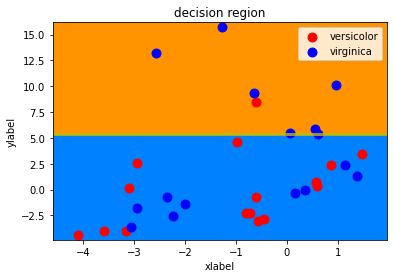

In [12]:
decision_region(X_train, y_train.ravel(), model=sdtc)

# 以降のアドバンス問題は時間の余裕がある時に行う。

# 5.より深い決定木

## 【問題7】（アドバンス課題）深さ2の決定木分類器クラスの作成
深さが2の決定木分類器のクラスScratchDecesionTreeClassifierDepth2を作成してください。

深さ2とは空間の分割を2回行うことを指します。


**《ヒント》**
各ノードをインスタンスとして扱うと、任意の深さへの拡張が行いやすくなります。

## 【問題8】（アドバンス課題）深さに制限のない決定木分類器クラスの作成
深さに制限のない決定木分類器のクラスScratchDecesionTreeClassifierDepthInfを作成してください。


任意の深さを指定できるようにするとともに、指定しない場合は全ての葉ノードがジニ不純度0となるまで続けられるようにもしてください。